In [1]:
import sys
sys.path.append("..")
from tqdm.notebook import tqdm
import torch

In [2]:
from mango.saving import load_from_file, save_to_file
from mango.utils.plotting import plot_agent_loss_reward
from mango.environments import frozen_lake
from mango.policies import DQNetPolicy
from mango import Agent

In [3]:
# parameters of the environment
p_frozen = 0.5
scale = 3
env_params = {
    "map_name": "RANDOM",
    "p": p_frozen,
    "shape": (2**scale, 2**scale),
    "goal_pos": [(0, 0), (-1, 0), (-1, -1), (0, -1)],
    "start_pos": [(0, 0), (-1, 0), (-1, -1), (0, -1)],
}

# agent parameters
gamma = 0.95
lr = 3e-4
net_params = dict(
    hidden_channels=[2*2**scale] + [2*2**scale, 2*2**scale] * max(0, (scale - 1)),
    hidden_features=[],
    activation_out=torch.nn.Sigmoid(),
    device=torch.device("cuda") if torch.cuda.is_available() else None,
)

# parameters of the training
N_episodes = 50 * 10 ** scale
train_steps_per_episode = 5
episode_length = env_params["shape"][0] * env_params["shape"][1]

In [4]:
dir_path = frozen_lake.utils.path_to_save_dir(env_params)

# agent that interacts with the environment
environment = load_from_file(path=dir_path+"option_manager.pickle").environment
agent = Agent(
    environment=environment,
    policy_cls=DQNetPolicy,
    policy_params=dict(lr=lr, gamma=gamma, net_params=net_params),
)

# agent that interacts with the option manager
option_manager = load_from_file(path=dir_path+"option_manager.pickle")
mango_agent = Agent(
    environment=option_manager,
    policy_cls=DQNetPolicy,
    policy_params=dict(lr=lr, gamma=gamma, net_params=net_params),
)

  0%|          | 0/50000 [00:00<?, ?it/s]

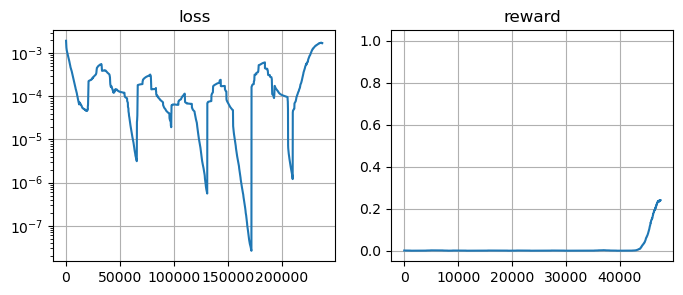

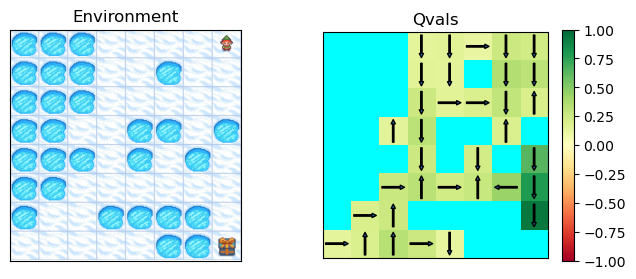

In [5]:
randomness = [((N_episodes - 1 - i) / N_episodes) for i in range(N_episodes)]
for r in (pbar := tqdm(randomness)):
    pbar.set_description(f"randomness: {r:.3f}")
    obs, reward, term, trunc, info = agent.explore(episode_length, randomness=r)
    for _ in range(train_steps_per_episode):
        agent.train()
save_to_file(path=dir_path + "/agent.pickle", obj=agent)
plot_agent_loss_reward(agent, reward_lims=(-0.05, 1.05), save_path=dir_path + "/agent_training.png")
frozen_lake.plot_utils.plot_all_qvals_agent(agent, save_path=dir_path + "/agent_qvals.png")